# Homework 4
Rex Wang
1. Create the opioid sqlite database from https://smart-stats.github.io/ds4bio_book/book/_build/html/sqlite.html. However, only go to the step where the csv files are read into the database. Then exit sqlite and you should have a file opioid.db that has the data. Next, read the three tables into pandas dataframes and do the remaining data wrangling from the sqlite chapter directly in pandas. Add the python code to your hw4.ipynb file.


In [3]:
import sqlite3 as sq3
import pandas as pd
import numpy as np

# create the connection
con = sq3.connect("opioid.db")

# read csv
annual = pd.read_sql_query("SELECT * from annual", con)
land = pd.read_sql_query("SELECT * from land", con)
population = pd.read_sql_query("SELECT * from population", con)

# fill in fips for Montgomery, AR
annual.loc[
    (annual["BUYER_STATE"] == "AR") & 
    (annual["BUYER_COUNTY"] == "MONTGOMERY"),
    "countyfips"
    ] = "05097"


2. Create a scatterplot of the average number of opioid pills by year by loading the sql database in python. [See the example here](https://www.opencasestudies.org/ocs-bp-opioid-rural-urban/#Data_Import). Don't do the intervals (little vertical lines), only the points.


In [4]:
# land area in 2010 with fips code
land2010 = land[["Areaname", "STCOU", "LND110210D"]].rename(columns={"STCOU": "countyfips"})

# assign land area to population
county_info = pd.merge(
    population,
    land2010,
    how="left",           # left join
    on="countyfips"       # key column
)

# # Convert columns to numeric (int or float)
# county_info["population"] = pd.to_numeric(county_info["population"], errors="coerce")
# county_info["LND110210D"] = pd.to_numeric(county_info["LND110210D"], errors="coerce")
# # calculate population density
# county_info["density"] = county_info["population"] / county_info["LND110210D"]

# # turn year into a category
# county_info["year"] = county_info["year"].astype("category")

# county_info["rural_urban"] = np.where(
#     county_info["density"] >= 500, 
#     "Urban", 
#     "Rural"
# )

# assign pop density to drug dosage
annual["year"] = annual["year"].astype("category")

all_data = pd.merge(
    annual,
    county_info,
    how="inner",           # inner join
    on=[
        "BUYER_COUNTY",
        "BUYER_STATE",
        "year",
        "countyfips"
        ]
)

# pills in millions
all_data["DOSAGE_UNIT"] = pd.to_numeric(all_data["DOSAGE_UNIT"])
all_data["Pills_in_millions"] = all_data["DOSAGE_UNIT"] / 1000000



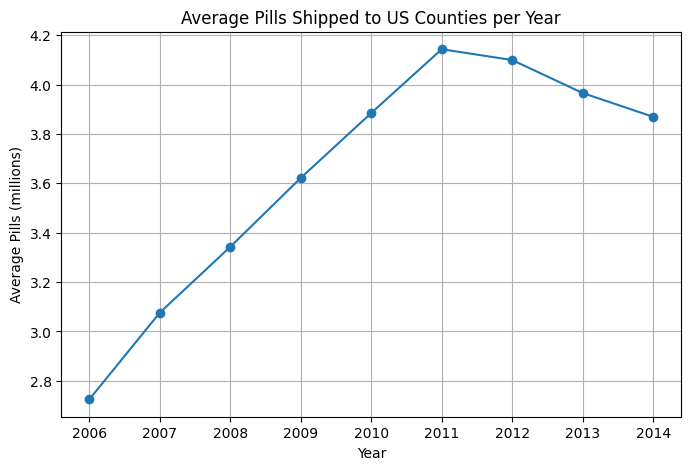

In [5]:
import matplotlib.pyplot as plt

# Compute average pills per county per year
avg_pills = all_data.groupby("year")["Pills_in_millions"].mean().reset_index()

plt.figure(figsize=(8,5))
plt.plot(avg_pills["year"], avg_pills["Pills_in_millions"], marker='o')
plt.title("Average Pills Shipped to US Counties per Year")
plt.xlabel("Year")
plt.ylabel("Average Pills (millions)")
plt.grid(True)
plt.show()


3. Repeat the steps of loading and merging the opioid data files in R. That is, follow the steps of loading and merging the three csv files as well as the data cleaning described in the notes in R.



4. Take your R code from the previous step and call it from python instead of R. Convert the resulting dataset to a pandas dataframe.

In [ ]:
# import os
# os.environ['R_HOME'] = r"C:\PROGRA~1\R\R-43~1.0"
# os.environ['R_USER'] = r"C:\Users\rexsw\Documents"

import rpy2.robjects as ro

ro.r(''' # The code runs fine in RStudio but here python can't seem to locate the libraries
library(dplyr)
library(tidyr)
library(tibble)
library(magrittr)
library(ggplot2)

# import data
annualDosage <- read.csv("county_annual.csv"); annualDosage <- as_tibble(annualDosage);
county_pop <- read.csv("county_pop_arcos.csv"); county_pop <- as_tibble(county_pop);
land <- read.csv("land_area.csv"); land <- as_tibble(land)

# select land area from 2010
land_area <- 
  land %>% 
  select(Areaname, STCOU, LND110210D)

# fill in fips code for Montgomery, AR
annualDosage %<>% 
  mutate(countyfips = case_when(BUYER_STATE == "AR" & 
                                BUYER_COUNTY == "MONTGOMERY" ~ 05097,
                                TRUE ~ countyfips))

# remove American terrirories with no fips code
annualDosage %<>% 
  filter(!is.na(countyfips))

# join population with land area
land_area %<>%
  rename(countyfips = STCOU) # match column name
county_info <- 
  left_join(x = county_pop, y = land_area, by = "countyfips")

# join county info with drug data
annualDosage %<>%
  mutate(countyfips = as.factor(countyfips),
         year = as.factor(year))
county_info %<>%
  mutate(countyfips = as.factor(countyfips),
         year = as.factor(year))
Annual <- 
  left_join(annualDosage, county_info, by = c("BUYER_COUNTY",
                                              "BUYER_STATE",
                                              "year",
                                              "countyfips"))

# remove NA
Annual %<>% 
  filter(!is.na(STATE))

# add column pills in millions
Annual %<>% 
  mutate(Pills_in_millions = DOSAGE_UNIT/1000000)

# plot mean pills per county per year
raw_average <- 
  Annual %>%
  ggplot(aes(x = year, y = Pills_in_millions, group = 1)) +
  stat_summary(fun = mean, geom = "point", size = 2) +
  labs(title = "Average Number of Opioid Pills Shipped to a US County",
       y = "Number of pills in millions") +
  theme_minimal()

raw_average
''')



R callback write-console: Error in library(dplyr) : there is no package called 'dplyr'
  


RRuntimeError: Error in library(dplyr) : there is no package called 'dplyr'
